This notebook will be testing different classification models and comparing them using classification reports and viewing confusion matrices. F1 score will be the dominant metric used since this is a multiclass problem, but other metrics like accuracy, precision and AUC (using a one vs. rest approach) will be considered, as well as visualizing class balance with confusion matrices

Our featureset going into modeling will be narrowed down to everything that could possibly make sense for pitch prediction. We'll re-evaluate features after testing the models, and may further reduce dimensions if it seems appropriate

The models will be trained and tested on just one pitcher, but we will validate the selected model on other pitchers to make sure it holds up. 

In [3]:

import pandas as pd
import numpy as np
df = pd.read_csv('../data/raw/chris_sale.csv')
df.head()

,game_pk,at_bat_number,pitch_number,pitch_type,pitch_type_map,is_fastball,balls,strikes,outs_when_up,inning,...,away_score,bat_score,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,prev_pitch_1,prev_pitch_2,prev_pitch_3,batter_is_right,pitcher_is_right,inning_top
0,744845,4,1,FF,0,1,0,0,0,1,...,0,0,1,0,NaN,NaN,NaN,0,0,0
1,744845,4,2,SL,4,0,0,1,0,1,...,0,0,1,0,0.0,NaN,NaN,0,0,0
2,744845,4,3,SL,4,0,0,2,0,1,...,0,0,1,0,4.0,0.0,NaN,0,0,0
3,744845,4,4,SI,1,0,1,2,0,1,...,0,0,1,0,4.0,4.0,0.0,0,0,0
4,744845,4,5,SL,4,0,1,2,0,1,...,0,0,1,0,1.0,4.0,4.0,0,0,0


In [4]:

cols_to_drop = ['home_score', 'away_score', 'pitch_type', 'game_pk', 'at_bat_number', 'is_fastball']
df = df.drop(columns=cols_to_drop, axis=1)
df = df.dropna()

Importing packages and implementing train and test sets. After running the default train/test sets using a 25% threshold, we will have to better account for class imbalance. I've imported the SMOTE technique to resample the data and better represent the smaller classes. 

In [5]:
#split into train-test-validate

from sklearn.model_selection import train_test_split, cross_val_score

# Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
# Metrics
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_curve,
    auc,
    confusion_matrix,
    classification_report,
)

# Plotting (for ROC curve and confusion matrix)
import matplotlib.pyplot as plt
import seaborn as sns

X = df.drop(columns=["pitch_type_map"])
y = df["pitch_type_map"]

#resampling the data due to class imbalance

from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.35, random_state=42)

class_mapping = {0: ' Fastball',
                1: 'Sinker',
                2: 'Cutter',
                3: 'Curveball',
                4: 'Slider',
                5: 'Changeup',
                6: 'Knuckle'}

label_encoder = LabelEncoder()

# Fit and transform y_train and y_test
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

/Users/cstone/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/cstone/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/Users/cstone/anaconda3/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Logistic Regression

Logistic Regression Accuracy: 0.41678224687933424
Logistic Regression F1 Score: 0.3932730785482685
Classification Report:
              precision    recall  f1-score   support

    Fastball       0.38      0.20      0.26       371
      Sinker       0.47      0.65      0.55       351
      Slider       0.41      0.26      0.32       375
    Changeup       0.38      0.59      0.46       345

    accuracy                           0.42      1442
   macro avg       0.41      0.42      0.40      1442
weighted avg       0.41      0.42      0.39      1442



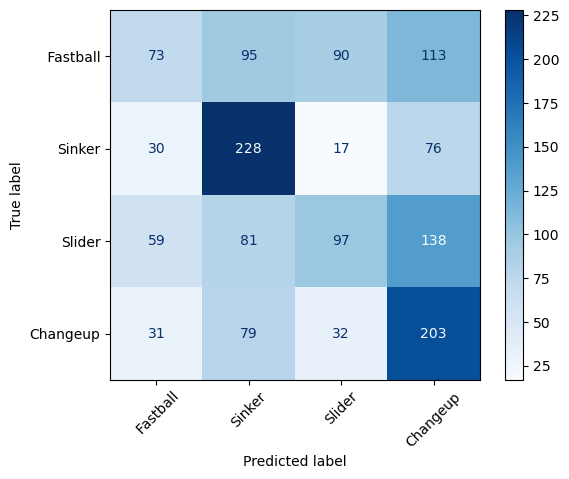

In [5]:
from sklearn.utils.class_weight import compute_class_weight



lr_model = LogisticRegression(random_state=43, max_iter=10000)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
y_pred_prob = lr_model.predict_proba(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_predictions))
print("Logistic Regression F1 Score:", f1_score(y_test, lr_predictions, average='weighted'))



from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
class_labels = df['pitch_type_map'].unique()


print("Classification Report:")
print(classification_report(y_test, lr_predictions, target_names=[class_mapping[c] for c in np.unique(y)]))
conf_matrix = confusion_matrix(y_test, lr_predictions)


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[class_mapping[c] for c in np.unique(y)])
disp.plot(cmap="Blues", xticks_rotation=45)



In [7]:
coef_df = pd.DataFrame(lr_model.coef_, columns=X_train.columns)
coef_df['Intercept'] = lr_model.intercept_

# Add class labels (optional)
coef_df['Class'] = lr_model.classes_

coef_df

,pitch_number,balls,strikes,outs_when_up,inning,bat_score,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,prev_pitch_1,prev_pitch_2,prev_pitch_3,batter_is_right,pitcher_is_right,inning_top,Intercept,Class
0,-0.064042,0.142500,0.074886,0.181837,0.089028,0.044596,0.170170,-0.517851,-0.034136,0.044924,0.004545,0.056676,0.0,0.365669,-0.589511,0
1,0.168412,-0.082234,-0.838795,-0.208611,-0.010275,-0.042803,-0.587787,0.636152,0.015733,0.028996,0.094767,-1.180957,0.0,-0.672112,1.972323,1
2,-0.227381,0.123838,0.685302,0.231889,0.106762,0.082907,0.328470,-0.612929,0.019511,-0.049734,-0.037685,-0.109592,0.0,0.485725,-0.762771,2
3,0.123012,-0.184103,0.078608,-0.205115,-0.185516,-0.084699,0.089146,0.494628,-0.001109,-0.024186,-0.061627,1.233872,0.0,-0.179282,-0.620041,3


K-Nearest Neighbors. A for loop was used to find the optimal K based on F1-score. The best K may change slightly on a per-pitcher basis but the f1-scores only varied by about .07 going across 30 K's. 

Classification Report:
              precision    recall  f1-score   support

    Fastball       0.40      0.22      0.28       371
      Sinker       0.47      0.78      0.59       351
      Slider       0.48      0.19      0.28       375
    Changeup       0.44      0.65      0.53       345

    accuracy                           0.45      1442
   macro avg       0.45      0.46      0.42      1442
weighted avg       0.45      0.45      0.42      1442

KNN F1 Score: 0.41520399050024975


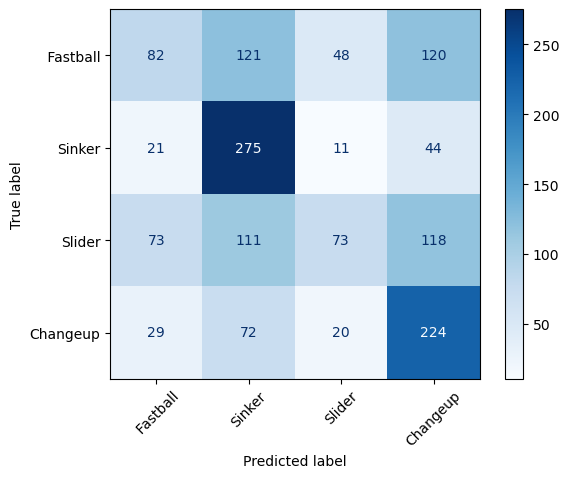

In [6]:
#model 2 KNN
# highest_acc = 0
# highest_f1 = 0
# best_k = 0
# for i in range(1,30):
#     knn_model = KNeighborsClassifier(n_neighbors= i)
#     knn_model.fit(X_train, y_train)
#     knn_predictions = knn_model.predict(X_test)
#     acc =  accuracy_score(y_test, knn_predictions)
#     f1 = f1_score(y_test, knn_predictions, average='weighted')
#     if acc > highest_acc:
#         highest_f1 = f1
#         highest_acc = acc
#         best_k = i
    
#     # print(f"KNN Accuracy for {i}:", accuracy_score(y_test, knn_predictions))

# print('Best K for KNN: ', best_k)
# print('KNN Accuracy: ', highest_acc)
# print('KNN F1 Score: ', highest_acc)

knn_model = KNeighborsClassifier(n_neighbors= 26)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)

    
conf_matrix_knn = confusion_matrix(y_test, knn_predictions)
#class_report = classification_report(y_test, lr_predictions, zero_division=0)



print("Classification Report:")
print(classification_report(y_test, knn_predictions, target_names=[class_mapping[c] for c in np.unique(y)]))
class_labels = df['pitch_type_map'].unique()

print("KNN F1 Score:", f1_score(y_test, knn_predictions, average='weighted'))


disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_knn, display_labels=[class_mapping[c] for c in np.unique(y)])
disp.plot(cmap="Blues", xticks_rotation=45)

Random Forest. The best hyperparameters were found with GridSearchCV. These may change on a per-pitcher basis and would make the model fairly slow to run each time. I'll validate later to find how much the hyperparameters change each time.

In [2]:

#Best Hyperparameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
#Model 3 Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


# rf = RandomForestClassifier()
# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 10, 20],
#     'min_samples_leaf': [1, 5, 10],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'bootstrap': [True, False]
# }


# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)

# grid_search.fit(X_train, y_train)

# print(f"Best Hyperparameters: {grid_search.best_params_}")


rf_model = RandomForestClassifier(bootstrap=True, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=500)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

#report
print("Classification Report:")
print(classification_report(y_test, rf_predictions, target_names=[class_mapping[c] for c in np.unique(y)]))

#overall metrics
print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))
print("Random Forest F1 Score:", f1_score(y_test, rf_predictions, average='weighted'))

class_labels = df['pitch_type_map'].unique()

#confusion matrix
conf_matrix_rf = confusion_matrix(y_test, rf_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=[class_mapping[c] for c in np.unique(y)])
disp.plot(cmap="Blues", xticks_rotation=45)

NameError: name 'X_train' is not defined

/Users/cstone/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [13:04:49] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.5957004160887656
XGBoost F1 Score: 0.5905304318761685
Classification Report:
              precision    recall  f1-score   support

    Fastball       0.49      0.44      0.47       371
      Sinker       0.77      0.82      0.79       351
      Slider       0.50      0.46      0.48       375
    Changeup       0.60      0.67      0.63       345

    accuracy                           0.60      1442
   macro avg       0.59      0.60      0.59      1442
weighted avg       0.59      0.60      0.59      1442



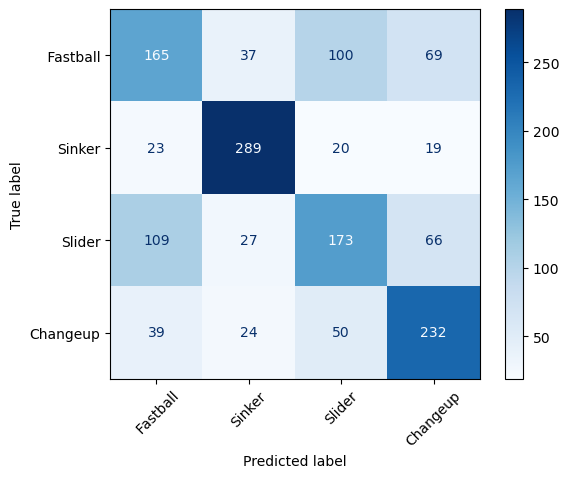

In [10]:
#Model 4 XGBoost

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder


# Define the model
xgb = XGBClassifier()


# Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'learning_rate': [0.01, 0.1, 0.3],
#     'max_depth': [3, 6, 10],
#     'min_child_weight': [1, 5, 10],
#     'subsample': [0.5, 0.7, 1.0],
#     'colsample_bytree': [0.5, 0.7, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'reg_alpha': [0, 0.1, 1],
#     'reg_lambda': [0, 0.1, 1]
# }

# # Set up GridSearchCV
# grid_search_xgb= GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, n_jobs=-1, verbose=20)

# # Fit the grid search
# grid_search_xgb.fit(X_train, y_train)

# print(f"Best Hyperparameters: {grid_search_xgb.best_params_}")

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=45)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_predictions))
print("XGBoost F1 Score:", f1_score(y_test, xgb_predictions, average='weighted'))



print("Classification Report:")
print(classification_report(y_test, xgb_predictions, target_names=[class_mapping[c] for c in np.unique(y)]))



#confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, xgb_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_xgb, display_labels=[class_mapping[c] for c in np.unique(y)])
disp.plot(cmap="Blues", xticks_rotation=45)

Validating our best model on some different pitchers

Classification Report:
              precision    recall  f1-score   support

    Fastball       0.29      0.12      0.17        34
      Sinker       0.50      0.63      0.56       302
      Cutter       0.40      0.10      0.16        20
      Slider       0.32      0.23      0.27       142
    Changeup       0.41      0.40      0.40       254

    accuracy                           0.44       752
   macro avg       0.38      0.30      0.31       752
weighted avg       0.42      0.44      0.42       752

Random Forest Accuracy: 0.4401595744680851
Random Forest F1 Score: 0.42291418074091386


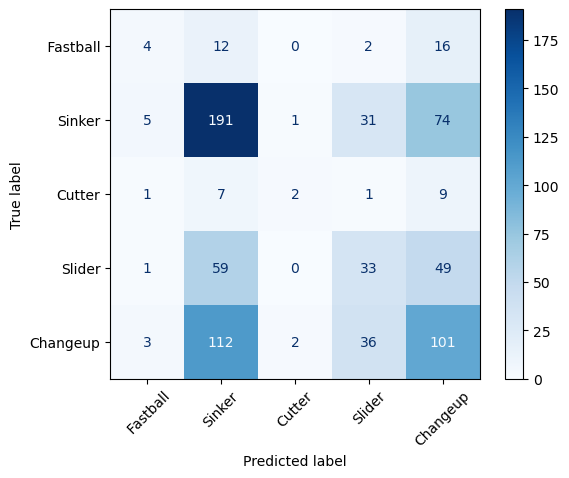

In [6]:
from sklearn.preprocessing import LabelEncoder

df_val = pd.read_csv('/Users/cstone/Documents/Projects/MLB_Pitch_Prediction/data/raw/logan_webb.csv')

df_val = df_val.drop(columns=['game_pk', 'pitch_type', 'is_fastball'])
Xval = df_val.drop(columns=['pitch_type_map'])
yval = df_val['pitch_type_map']




Xvaltrain, Xvaltest, yvaltrain, yvaltest = train_test_split(Xval, yval, test_size=0.25, random_state=41)


rf_model_val = RandomForestClassifier(bootstrap=True, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=2, n_estimators=500)
rf_model_val.fit(Xvaltrain, yvaltrain)
rf_predictions_2 = rf_model_val.predict(Xvaltest)

#report
print("Classification Report:")
print(classification_report(yvaltest, rf_predictions_2, target_names=[class_mapping[c] for c in np.unique(yval)]))

#overall metrics
print("Random Forest Accuracy:", accuracy_score(yvaltest, rf_predictions_2))
print("Random Forest F1 Score:", f1_score(yvaltest, rf_predictions_2, average='weighted'))

class_labels = df['pitch_type_map'].unique()

#confusion matrix
conf_matrix_rf = confusion_matrix(yvaltest, rf_predictions_2)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf, display_labels=[class_mapping[c] for c in np.unique(yval)])
disp.plot(cmap="Blues", xticks_rotation=45)

Classification Report (One-vs-Rest):
              precision    recall  f1-score   support

    Fastball       0.26      0.15      0.19        34
      Sinker       0.50      0.64      0.56       302
      Cutter       0.50      0.10      0.17        20
      Slider       0.33      0.23      0.27       142
    Changeup       0.43      0.41      0.42       254

    accuracy                           0.45       752
   macro avg       0.40      0.30      0.32       752
weighted avg       0.43      0.45      0.43       752

OvR Random Forest Accuracy: 0.44680851063829785
OvR Random Forest F1 Score: 0.42898264298952593


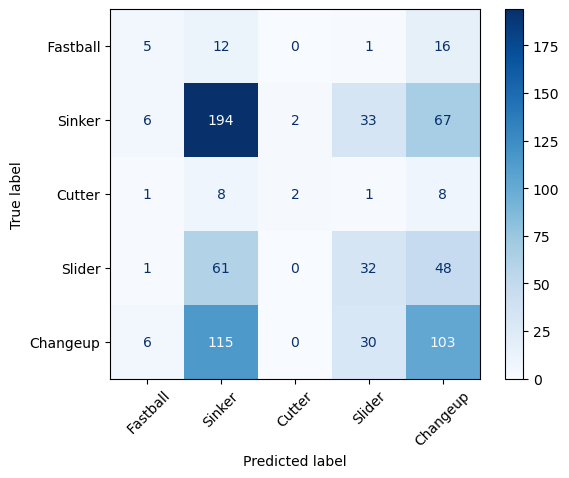

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import numpy as np

# Load and prep data
df_val = pd.read_csv('/Users/cstone/Documents/Projects/MLB_Pitch_Prediction/data/raw/logan_webb.csv')
df_val = df_val.drop(columns=['game_pk', 'pitch_type', 'is_fastball'])

Xval = df_val.drop(columns=['pitch_type_map'])
yval = df_val['pitch_type_map']

# Train/test split
Xvaltrain, Xvaltest, yvaltrain, yvaltest = train_test_split(Xval, yval, test_size=0.25, random_state=41)

# One-vs-Rest wrapper around Random Forest
base_rf = RandomForestClassifier(
    bootstrap=True,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=500,
    random_state=42
)
ovr_rf_model = OneVsRestClassifier(base_rf)
ovr_rf_model.fit(Xvaltrain, yvaltrain)

# Predictions
rf_predictions_ovr = ovr_rf_model.predict(Xvaltest)

# Report
print("Classification Report (One-vs-Rest):")
print(classification_report(yvaltest, rf_predictions_ovr, target_names=[class_mapping[c] for c in np.unique(yval)]))

# Overall metrics
print("OvR Random Forest Accuracy:", accuracy_score(yvaltest, rf_predictions_ovr))
print("OvR Random Forest F1 Score:", f1_score(yvaltest, rf_predictions_ovr, average='weighted'))

# Confusion matrix
conf_matrix_rf_ovr = confusion_matrix(yvaltest, rf_predictions_ovr)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_rf_ovr, display_labels=[class_mapping[c] for c in np.unique(yval)])
disp.plot(cmap="Blues", xticks_rotation=45)


Predictably, the more pitches a pitcher has, the less accurate and specific the model will be overall. However, we are still maintaining between 40-50% F1 score for the other pitchers we've tried. Given most starting pitchers have a minimum of 4 pitches, this at least doubles our odds of prediciting pitch type, as opposed to just guessing what pitch is coming. 

Creating a One vs Rest model to examine ROC curve of each class

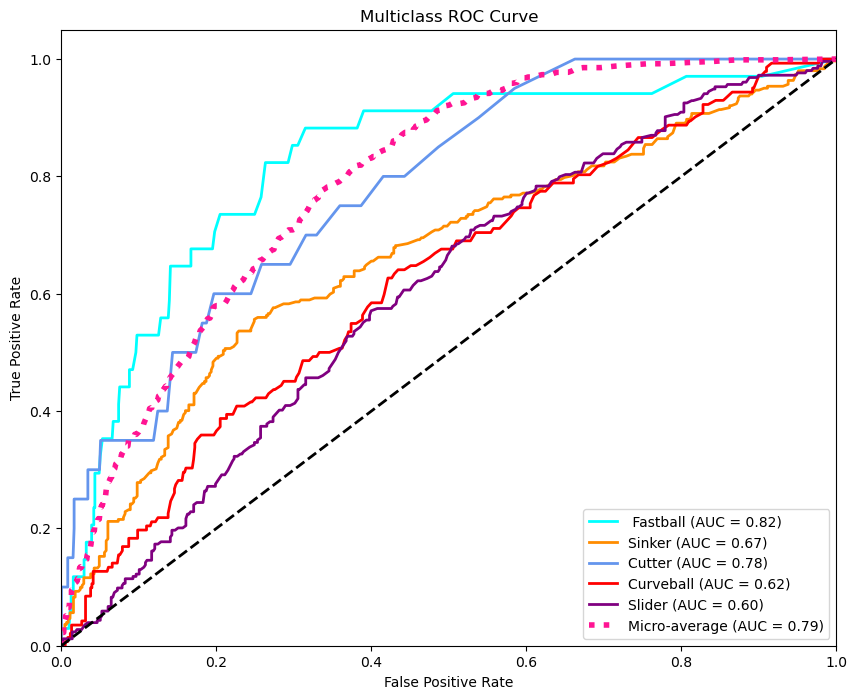

In [125]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt


yvaltrain_binarized = label_binarize(yvaltrain, classes=np.unique(yval))
yvaltest_binarized = label_binarize(yvaltest, classes=np.unique(yval))
n_classes = yvaltrain_binarized.shape[1]
rf_model_val_ovr = OneVsRestClassifier(RandomForestClassifier(
    bootstrap=True, max_depth=None, max_features='sqrt', 
    min_samples_leaf=1, min_samples_split=2, n_estimators=500
))
rf_model_val_ovr.fit(Xvaltrain, yvaltrain_binarized)


y_score = rf_model_val_ovr.predict_proba(Xvaltest)


fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yvaltest_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


fpr["micro"], tpr["micro"], _ = roc_curve(yvaltest_binarized.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


plt.figure(figsize=(10, 8))

colors = ['aqua', 'darkorange', 'cornflowerblue', 'red', 'purple', 'green', 'brown']
for i, color in zip(range(n_classes), colors[:n_classes]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"{class_mapping[i]} (AUC = {roc_auc[i]:.2f})")

# Plot the micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f"Micro-average (AUC = {roc_auc['micro']:.2f})",
         color="deeppink", linestyle=":", linewidth=4)

# Plot the diagonal (random performance)
plt.plot([0, 1], [0, 1], "k--", lw=2)

# Add labels and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multiclass ROC Curve")
plt.legend(loc="lower right")
plt.show()


Show feature importance scores

In [1]:
feature_importances = rf_model_val.feature_importances_


features = X_resampled.columns  
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})


importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis() 
plt.show()

NameError: name 'rf_model_val' is not defined

Interestingly, at_bat_number is our most significant feature. So if a batter is being seen for the first, second  or third time can be a decent predictor of pitch_type. Simalarly, pitch_number is also pretty high on the list. I feel both are important to keep as a pitch count can be high, even if it's stil the first time thru the order

Then, the previous 3 pitches thrown appear to be good predictors as well. This makes sense as pitches are often thrown in sequnces (such as first pitch fastballs, two_strike curveballs etc.)

Notably, whether the pitcher is right or left handed seems to have no impact. However the batter's handedness does seem to matter. 